<a href="https://colab.research.google.com/github/IEXE-Tec/mcda-marketing/blob/main/04_05_ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A/B Testing**

Este Notebook esta basado en varis de los ejemplos que vienen en la pagina de Kaggle.

En este Colab diseñaremos, crearemos y evaluaremos una prueba A/B: 


1. Diseñaremos el Experimento 
2. Recollecion de Datos y ETL
3. EDA 
4. Pruebas de Hipotesis
5. Analisis de Resultados

In [ ]:
# Packages imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

%matplotlib inline
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Diseño de Experimento

Imagina que estas analizando los datos de suscripcion a un servicio como Medium que maneja suscripciones anuales de 200. Y se pagan en una sola exhibicion.

Imagina que tu marca ha decidido rediseñar su pagina de internet con el fin de obtener mas conversiones. Tu fronted UX/UI esta listo para implementar el nuevo layout de la pagina. El objetivo de este rediseño es aumentar el numero de conversiones, que en este caso es que los usuarios creen una cuenta.  

Tu primera tarea es diseñar el experimento y explicar el diseño a tu equipo.

Ademas ya realizaste un analisis exploratorio de los datos y decidiste que primero evaluaran un efecto agregado sin segmentar los grupos.

## Diseño de la prueba de hipotesis

Como es costumbre comenzaremos estableciendo la prueba de hipotesis. Definamos:  
$p_0:= \text{ la probabilidad de conversion de la pagina original.}$  
$p:=\text{ la probabilidad de conversion de la pagina rediseñada}$

### Hipotesis nula

En este caso la hipotesis nula $H_0$ es que el nuevo diseño de la pagina no afecta el numero de conversiones:  


> $H_0: \ \ \ \ \ \   p=p_0$  







### Hipotesis Alternativa

El rediseño de la pagina afecta la probabilidad de conversion:  
> $H_1: \ \ \ \ \ \   p \neq p_0$ 
   
Nota que la hipotesis es que es diferente, no indica si aumento o disminuyo con el rediseño. Esto quiere decir que usaremos una [prueba de dos colas](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)  

### Nivel de significancia

En este caso como es costumbre utilizaremos un nivel de significancia de $5%$ como es constumbre:  
> $ \alpha=.05$  

Esto quiere decir que nuestro nivel de confianza es de $95%$, oues:  
> $(1- \alpha) = .95$

## Grupos de Control

En este caso el grupo de **control** recibira el diseño viejo, y el grupo de **tratamiento** recibira el nuevo diseño.

No te preocupes en este caso el equipo de front te garantiza que la pagina que se mostrara al usuario es **completamente aleatoria**.

## Efecto Minimo

Dado que als subscripciones que ofrecen son anuales, y por politicas internas el analisis se debe realizar a nivel anual. 

Tu equipo te pasa las siguientes metricas:
+ CPC = 5
+ Costo de Mantenimiento Anual de los usuarios es $Co = 100$
+ CLTV Anual despues de Convertir sin costos es $V = 200$
+ El CLTV con costos es = $V - C_0 = (200-100)$
+ La conversion actual es .12 osea $p_0=.12$

Esto implica que el **CLTV esperado** por usuario que da click en el anuncio es:  
+ $p_0 \times (V-Co) - CPC = .12 \times (200-100) - 5 = 7$  

Nota que nostros estamos hablando de el **Valor Esperado del CLTV** no del **CLTV** como tal, pues no estamos evaluando el efecto del rediseño en el gasto del usuario una vez que se suscribe:
+ **CTVL** = 200 - 100. Este se queda fijo, pues es una metrica definida por la empresa, y esta condicionado a que la persona ya se sucribio!! Ten mucho cuidado con el lenguaje, modos y definiciones de la empresa!!! Sobre todo al momento de comunicar resultados. Esta definicion **no incluye costos de adquisicion solo costos de mantenimiento y la subscripcion**. Si no estas seguro de la definicion de alguna metrica pregunta, pues puede que en ocasiones sea diferente o igual a lo que esperas.
+ Nuestro **CLTV esperado** incluye los costos de adquisicion, es el **CLTV** de todos nuestros compradores potenciales, por eso incluye los costos de adquisicion como lo es el CPC, y tambien la probabilidad de suscribirse $p \ \& \ p_0$.  
Para evitar mas confuciones devinamos el **CTVL esperado** como $E$.


Donde:  
+ $p_0 \times (V-Co)$  es la venta esperada para cualquier usuario que vea nuestro anuncio, de ahi que la multipliquemos por $p_0$. Solo vendemos $V$ y pagamos $Co$ si el usuario convierte.  
+ CPC es el gasto promedio por usuario que es redirigido a nuestra pagina, por eso no hay que multiplicarlo. En promedio el costo por click es 5, la probabilidad de dar click ya viene implicita en la metrica.

Grafiquemos cuanto cambio nuestro **E** dada nuestra nueva conversion $p$, sin incluir costos de rediseño:
+ Cambio en proporciones es $\Delta_p = p-p_0$
+ Cambio en el **E** sin costos de rediseño: $\Delta_{E}=(p-p_0) \times (V-Co)$ 
>   $\Delta_{E} = (\Delta_p) \times (200-100) = \Delta_p*100 $  
El CPC se mantiene constante y no es incluido en la ecuacion, pues el rediseño es de la pagina no de la forma en que llegan lo usuarios por lo que no afecta la proporcion de clicks.

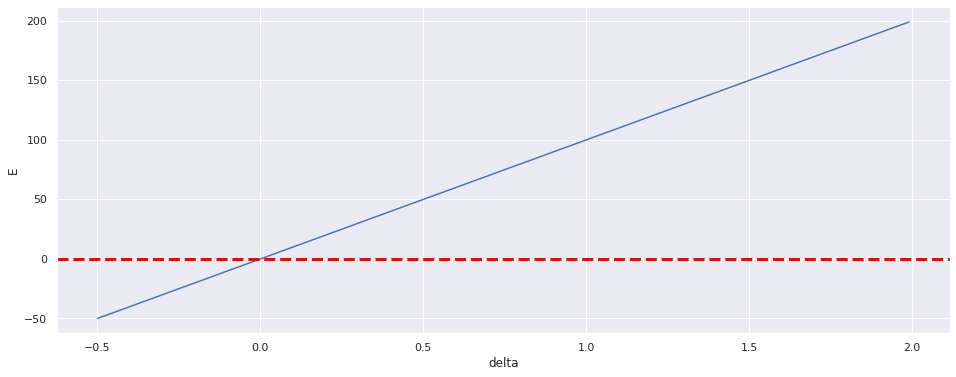

In [ ]:
delta = pd.Series(list(range(-50,200,1)))/100
# E
cltv = 100*delta

evaluacion = pd.DataFrame({'delta':delta, 'E':cltv})
sns.lineplot(data=evaluacion, x='delta', y='E')
plt.axhline(0, ls='--', linewidth=3, color='red')

Bueno dado que nuestro modelo es lineal, el comportamiento es lineal. Sin embargo esta es la metodologia a seguir sin importar que el modelo no sea lineal.

Ahora veamos como cambiarian nuestros ingresos mensuales. Para ello debemos incluir el numero de usuarios que realmente ven nuestra pagina (independientemente si convierten o no). 
+ Sea $m$ el numero de personas que dan click y cargan nuestra pagina.
$m$ es casi equivalente a los clicks que tenemos, menos las personas que se salen antes de ver la pagina y los usuarios que entran mas de nos veces. Por ahora es una buena aproximacion.

De analizar los modelos anteriores aprece que en promedio **$m$ es de 95 mil** usuarios al mes. Y dado que es un A/B testing y la forma de redirigir a los potenciales usuarios a la pagina no cambiara es una buena proyeccion.

Esto quiere decir que dado que **el usuario es redirigido a nuestra pagina**:
+ El promedio de ususarios que convierten mensualmente es: $p_0 \times m$
+ El promedio de usuarios que conviertiran bajo el rediseño es: $p \times m$
+ El cambio en el promedio de usuarios que convierten:  $(p - p_0) \times m$

Ahora calculemos como cambiaria el **Ingreso Mensual** dependiendo de $p$. Esto no es mas que:  
+ Cambio en el Ingreso Mensual:  $\Delta_{ingreso}=\Delta_{E}*m = \Delta_p*100 \times m$  
Nota que no dividimos $E$ entre doce meses, pues el usuario paga toda la suscripcion en una exhibicion.


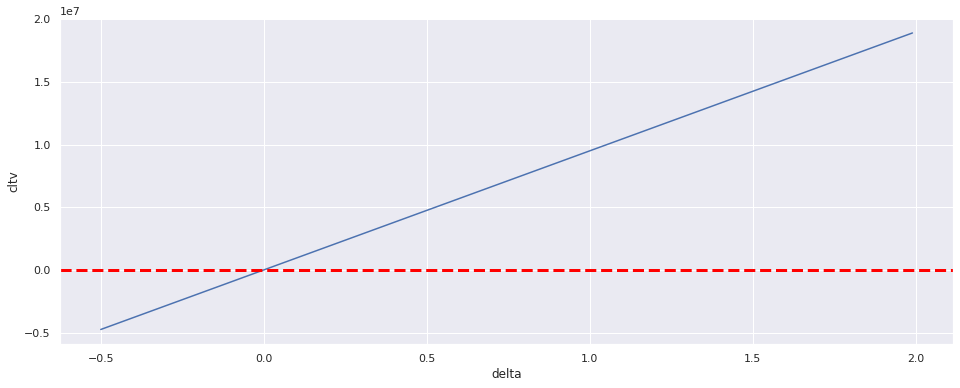

In [ ]:
delta = pd.Series(list(range(-50,200,1)))/100
cltv = 100*delta*95000

evaluacion = pd.DataFrame({'delta':delta, 'cltv':cltv})
sns.lineplot(data=evaluacion, x='delta', y='cltv')
plt.axhline(0, ls='--', linewidth=3, color='red')

De nuevo dado que nuestros costos e ingresos son lineale sno hay mucho que interpretar.

Sea $R$ el costo del rediseño, y de las modificaciones necesarias a la infraestructura. Osea el costo del proyecto o campaña.

Ahora pasemos a algo mas interesante. Veamos cuanto tendria que ser $p$ para **cubrir los costos de rediseño de la pagina en un mes**. Esto equivale a encontrar el punto donde las ganancias extras generadas por los nuevos usuarios son iguales al costo de rediseño. Llamemos a esta $p$ que cubre los gastos en un mes $p_e$ o $p$ de equilibrio de tal forma que:  

Matematicamente equivale a despejar $p$ de la siguiente ecuacion (ignoramos el CPC pues esa variable no se vera afectada y ya viene en promediada):  
+ $R = \Delta_E \times m $
+ $R = \Delta_p*(V - C_o) \times m $
+ $R = (p-p_0)*(V - C_o) \times m$  


Tambien podemos ver el problema a nivel mensual como:
+  El cambio del Ingreso esperado de nuestra politica, **por usuario que ingresa a la pagina**.: 
> > > $\Delta_E = p(V - C_o) - p_0(V-C_o)$
+ El cambio del Ingreso esperado de nuestra politica, **por todos los usuarios que ingresan a la pagina**:  
> > > $m \times \Delta_E = m \times [p(V - C_o) - p_0(V-C_o)]$  

+ Este cambio debe cubrir por lo menos el costo $R$ de implementacion:
> > > $R \leq m \Delta_E$  

+ Si queremos quedar iguales, pues cambia,
os " $\leq$ " por "$=$" y despejamos.  
Cualquier $p$ tal que:  
> > > "$R < m \Delta_E =  (p - p_0)(V - C_o)m$" nos hace Ganar dinero. Y en el momento que se iguale habremos cubierto los cosots de implementacion $R$. 


El despeje es:
> > > $p_e = \frac{R}{100 \times m} + p_0$  
Sustituyendo con la informacion que conocemos queda como:  
> > > $p_e = \frac{R}{100 \times 95000} + .12$


Supongamos que $R$ es de 1.5 millones, lo que nos daria una p_e de:
> > > $p_e \approx .277$

De tal forma que cualquier $p > p_e$ nos hace ganar dinero.

Esto implica un aumento de $15.7$% en la conversion. Lo cual puede ser muy alto, pues por experiencias anteriores sabes que los cambios son muy pequeños. Pero no hay problema, pues dado los planes futuros de la empresa estan dispuestos a invertir en el rediseño si el costo se cubre en un año. 

La matematica seria la siguiente:
+ El cambio del Ingreso esperado de nuestra politica, **por usuario que ingresa a la pagina**:
> > > $\Delta_E = p(V - C_o) - p_0(V-C_o)$ 
+  El cambio del Ingreso esperado de nuestra politica, **por todos los usuarios que ingresan a la pagina**: 
> > >$m \times \Delta_E = m \times [p(V - C_o) - p_0(V-C_o)]$
+ El cambio del Ingreso esperado de nuestra politica, **durante t meses**. Recuerda que cada mes entran $m$ usuarios a la pagina.  : 
> > > $t \times m \times \Delta_E = t \times m \times [p(V - C_o) - p_0(V-C_o)]$  
+ Este cambio debe cubrir por lo menos el costo $R$ de implementacion:
> > > $R \leq tm \Delta_E$  
+ Si queremos quedar iguales, pues cambia,os "$\leq$" por "$=$" y despejamos.  
Cualquier $p$ tal que 
> > >"$R < tm \Delta_E =  (p - p_0)(V - C_o)tm$"   nos hace Ganar dinero. Y, en el momento que se iguale habremos cubierto los costos de implementacion $R$.  


Esto nos daria una nueva $p_e$ de: 
> > > $p_e = \frac{R}{100 \times m \times t} + p_0$   

Donde $t$ es el numero maximo de meses en los que la empresa esta dispuesta a cubrir el costo $R$.  
> > > $ p_e = \frac{R}{100 \times 95000 \times 12} + .12$  

> > > $ p_e \approx .133 $

El cambio que esperamos es de $1.3$% Dado que el resultado de cambios similares en el pasado ha traido un incremento de mas o menos $3$% parece una idea sensata.

Nota que en estricto sentido, podrias dejar $p_0$ como **incognita**. Imagina que vives en un mundo donde *a priori* **no conoces** $p_0$. Bueno pues sin importar su valor podrias calcular el cambio necesario $\Delta_{p_e} = p_e - p_0$: 
> > > $ p_e - p_0 = \frac{R}{100 \times m \times t} $ 
     
> > > $ p_e - p_0 = \frac{R}{100 \times 95000 \times 12}$  
  
> > > $p_e - p_0 \approx .0133 $

## Tamaño de Muestra

 De terminemos el poder o potencia de nuestro analisis de nuestra prueba. Que depende de 3 factores:  
 > + [Poder Estadistico](https://es.wikipedia.org/wiki/Poder_estad%C3%ADstico) de nuestra prueba:= Este se define como la probabilidad de encontrar una diferencia estadisticamente significativa entre los dos grupos, **dado que la diferencia existe**. Generalmente se utiliza un valor de $.8$ 
 > + [Nivel de significancia](https://es.wikipedia.org/wiki/Significaci%C3%B3n_estad%C3%ADstica): Es la $\alpha$ que decidimos previamente y se define como la probabilidad de rechazar la hipotesis nula dado que es verdadera.  
 > + Efecto: Que tan grande es el efecto de nuestra muestra.


### Calculemos el tamaño de la muestra

+ [sms.proportion_effectsize()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html)
+ [sms.NormalIndPower()](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.NormalIndPower.html): Usamos una normal pues estamos calculando una diferencia de proporciones.

In [ ]:
# Calculando el tamaño del efecto
efecto = sms.proportion_effectsize(0.12, 0.133) 

# Calculemos el minimo tamaño de muestra que necesitamos
n_muestra = sms.NormalIndPower().solve_power(
    efecto, 
    power=0.8, 
    alpha=0.05 
    )                                                  

print(n_muestra)

10257.418429123316


Bueno nuestro minimo tamaño de muestra es de **10258 individuos por grupo**.

Dado que el $m$ es de 95mil usuarios en promedio, asignando una probabilidad de $50$% para ser control o tratamiento obtendriamos mas de los necesarios.

### Duracion del experimento

Dado que no existe ninguna prisa por evaluar los resultados, el equipo decide que el experimento se llevara acabo durante 3 meses, de esta manera tu tamaño de muestra sera mucho mayor al esperado.

# ETL

Por ahora imaginemos que el experimento ya se implemento, y estas accediendo a los resultados. Dada las limitaciones actuales seria muy dificil implementar el experimento 100% en la clase.  
En la realidad los datos los obtuvimos de [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv)

In [ ]:
ab = pd.read_csv('https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ab_data.csv')
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
ab.shape

(294478, 5)

In [ ]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# EDA

## Usuarios

### Usuarios en los dos grupos

In [ ]:
ab.groupby(['group'])['converted'].count()

group
control      147202
treatment    147276
Name: converted, dtype: int64

In [ ]:
ab['user_id'].nunique()

290584

In [ ]:
id_trat = ab[ab['group']=='treatment']['user_id']
id_control = ab[ab['group']!='treatment']['user_id']
print(f'Usuarios con tratamiento: {id_trat.nunique()}')
print(f'Usuarios en control: {id_control.nunique()}')


Usuarios con tratamiento: 146284
Usuarios en control: 146195


In [ ]:
id_filtrado = id_trat[id_trat.isin(id_control)]
print(f'Usuarios en los dos grupos: {id_filtrado.nunique()}')

Usuarios en los dos grupos: 1895


En este caso hay solo hay 1895 usuaarios que estan los dos grupos. Desagamonos de ellos por le momento, aunque en un futuro podria servir para evaluar el efecto repetido de la pagina, pero en este momento son tan pocos que no vale la pena.

In [ ]:
ab = ab[~ab['user_id'].isin(id_filtrado)]

### Usuarios repetidos

In [ ]:
usuarios_duplicados = ab.drop_duplicates('user_id').shape[0]
print(ab.shape)
print(usuarios_duplicados)
print(f"Diferencia {ab.shape[0] - usuarios_duplicados}")

(290688, 5)
288689
Diferencia 1999


En este caso la diferencia es tan pequeña, y tenemos tantos datos que podemos eliminarlos o dejarlos.

In [ ]:
sesiones = ab['user_id'].value_counts(ascending=False)
ids_repetidos = sesiones[sesiones > 1].index
ab = ab[~ab['user_id'].isin(ids_repetidos)]
print(ab.shape)

(286690, 5)


In [ ]:
ab.groupby(['group'])['converted'].count()

group
control      143293
treatment    143397
Name: converted, dtype: int64

Bueno despues de limpiar los datos observamos que seguimos teniendo mucho mas usuarios de los requeridos, lo que es buena señal.

## EDA de resultados

In [ ]:
prob_conversion = ab.groupby('group')['converted']

# Std de la conversion
std_p = lambda x: np.std(x, ddof=0)             
# Error estandar
se_p = lambda x: stats.sem(x, ddof=0)       

prob_conversion = prob_conversion.agg([np.mean, std_p, se_p])
prob_conversion.columns = ['conversion_rate', 'std_deviation', 'std_error']


prob_conversion.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


Inmediatamente notamos que la conversiones son muy similares, osea $p$ e smuy cercano a $p_0$.  
+ $p_0=.12$
+ $p=.119$

# Prueba de hipotesis

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
# Calculemos los usuarios en cada grupo
control = ab[ab['group'] == 'control']['converted']
tratamiento = ab[ab['group'] == 'treatment']['converted']
n_con = control.count()
n_trat = tratamiento.count()
successes = [control.sum(), tratamiento.sum()]
nobs = [n_con, n_trat]
nobs

[143293, 143397]

+ [proportions_ztest()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html): Test de proporciones z.
+ [proportion_confint()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html): Calcular los intervalos de confianza para nuestros estimadores $p$ y $p_0$.

In [ ]:
# Test de proporciones
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Intervalo de confianza para p_0 al 95%: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Intervalo de confianza de p al 95%: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
Intervalo de confianza para p_0 al 95%: [0.118, 0.122]
Intervalo de confianza de p al 95%: [0.117, 0.120]


# Conclusiones

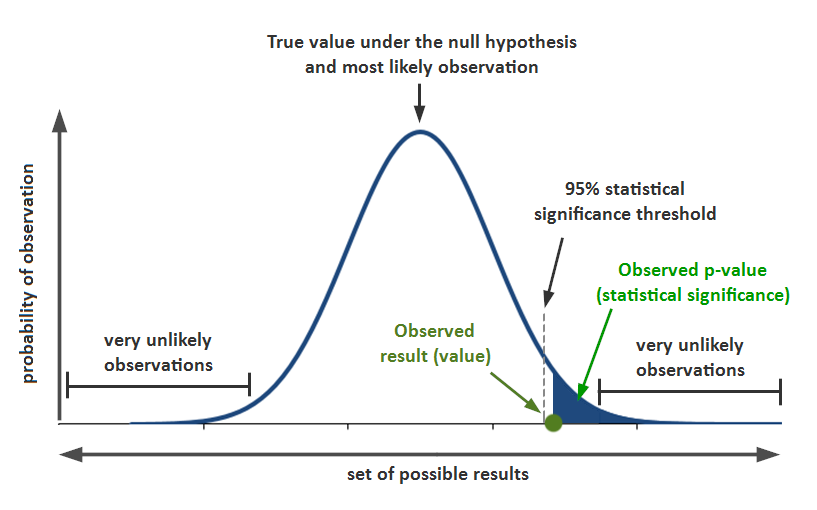

Dado que nuestro **p-value** fue de un terrible $.232$ muy lejos de nuestra $\alpha$ de $.05$ no tenemos evidencia que soporte rechazar $H_0$. Recordemos que $H_0$ es $p=p_0$ lo que quiere decir que el rediseño probablemente no tubo ningun efecto.

Ademas observando nuestros intervalos de confianza al $95$% podemos obserbar que nuestro efecto deseado de por lo menos $15$% no se encuentra ahi:


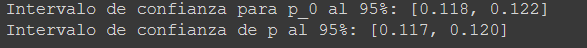

Es mas incluso el efecto de la nueva pagina parece ser negativo en el mejor caso! No pasa nada, estos resultados aveces pasan...

Bueno, aunque puede que nuestro plan estubiera mas desde le inicio.

## Retrospectiva (Examen)

### Falta de Analisis de alternativas y definicion de objetivos

Para empesar por que se decidio hacer un rediseño tan costoso de la pagina? Puede que fuera mas facil hacer experimentos para bajar el CPC. o incluso ofrecer promociones.  

**Por que paso esto?** Si lo piensas detenidamente en ningun momento hubo un analisis de objetivos. El objetivo fue cambiar el diseño web para incrementar las ventas? Bueno eso esperamos, pero no hubo ninguna discusion al respecto ni analisis. Simplemente se decidio cambiar las ventas.  

#### Tarea

Evalua un proyecto alternativo donde se aplique un descuento $d$ a los usuarios.  
Pagarian $(1-d)V$ por la suscripcion.
+ Imagina que el $R_d$ el costo de implementar el descuesto es de 10000, pues solo hay que realizar un banner nuevo y realizar pocas modificaciones a la arquitectura.
+ Encuentra la ecuacion para estre proyecto alternativo, no olvides que falta incorporar $d$ que es un porcentaje de descuento en la suscripcion anual. Recuerda que la ecuacion anterior es: 
> > > $\Delta_E = p(V - C_o) - p_0(V-C_o)$   
Pon especial atencion a los terminos  $p(V - C_o)$ & $p_0(V-C_o)$, que cambia en cada uno?
+ En cuenta $ p_e$ en funcion de $d$ para esta nueva politica.
+ Calcula los diferentes $p_e$ para los siguientes valores de $d$  
> > > `d = pd.Series(list(range(-20,21,1)))/100`  
Hint: $p_e$ no se comporta lineal respecto a $d$.
+ Evalua la posibilidad de aumentar el precio de la suscripcion osea $d$ positiva.
    + Que tando puede caer $p_e$ respecto a $p$ sin afectar los ingresos? En otras palabras que tan negativo puede ser $\Delta_p$ para los diferentes aumentos de precio (osea $d$s positivas)?
+ Ahora que tines $p_e$ en funcion de $d$ -> Calcula $\Delta_{p_e} $ en funcion de $d$. Cuanto tendria que ser el cambio entre $p$ y $p_0$ en funcion de $d$ para cubrir exactamente el costo del proyecto? (usa $t=12$, y el mismo rango de valores de `d = pd.Series(list(range(-20,21,1)))/100`).
  


Recuerda que: 
Tu equipo te pasa las siguientes metricas:
+ CPC = 5
+ Costo de Mantenimiento Anual de los usuarios es $Co = 100$
+ CLTV Anual despues de Convertir sin costos es $V = 200$
+ El CLTV con costos es = $V - C_0 = (200-100)$
+ La conversion actual es .12 osea $p_0=.12$

In [ ]:
# Rango de Porcentajes de cambio para graficar
d = pd.Series(list(range(-20,21,1)))/100
# Completa pe
pe = 
df = pd.DataFrame({'pe':pe, 'd':d})
sns.lineplot(data=df, x='d', y='pe')

In [ ]:
# Completa delta_pe
df['delta_pe'] = 
sns.lineplot(data=df, x='d', y='delta_pe')

### Duracion

Dos, hubo perdidas mayores por extender el A/B testing a 3 meses. Un mes o incluso 1 semana bastaba para probar nuestra hipotesis. Si nuestra politica era mala y los costos de mantener el nuevo sitio web eran altos lo mejor que pudimos hacer era evaluar resultados rapidamente para evitar perdidas.  
Si el efecto no era el esperado lo mejor era buscar soluciones de manera rapida, cambiar, modificarse y adaptarse.

#### Tarea

Estima la duracion minima **esperada** del proyecto en dias si asumes que cada dia de la semana llegan $m/30$ usuarios a tu pagina. Osea que la distribucion de llegada de usuarios es casi uniforme durante los dias del mes. 

### Implementacion

Realmente era necesario gastar 1.5 millones en crear una nueva pagina?  
No era mas facil hacer un Mock Up o una pruba de concepto mas sencilla con menor costo para evaluar el proyecto?  
  


#### Tarea

Ve el siguiente vide: https://www.youtube.com/watch?v=peK4xFdji8I 
En el Jake Knapp & John Zeratsky de Google Ventures. En el nos explican en que consiste la metodologia de Sprint que nos permite probar ideas de manera rapida y no muy costosa. Ademas, nos muestran algunos ejemplos.  
Esta metodologia alternativa puede que nos ayude a evitar errores como estos en la realidad

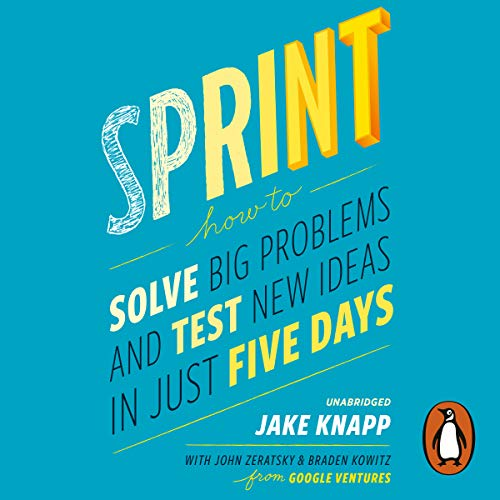